In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
import os
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.visualization import simple_norm
import tqdm
import requests
from scipy.optimize import curve_fit
import numpy.ma as ma
from scipy.special import wofz

from sqlalchemy import text

loc = '/Users/allybaldelli/SIMPLE-db'
sys.path.append(os.path.abspath(loc))

# Importing scripts needed 
from curvefit import *
from models import *

### Getting data from Simple-db and organizing it 

In [6]:
# getting simple data
from astrodbkit2.astrodb import create_database, Database
from simple.schema import *

# connection string for a SQLite database named SIMPLE.db
connection_string = 'sqlite:///SIMPLE.db'
create_database(connection_string)
db = Database(connection_string)

db.load_database('/Users/allybaldelli/SIMPLE-db/data/')

100%|██████████| 3187/3187 [00:12<00:00, 263.86it/s]


In [11]:
#  creating dict of sources and spectra
dict_of_spectra = {}
sources = db.query(db.Spectra.c.source).filter(
    db.Spectra.c.mode == 'SXD').all()
sources = [str(source).split("'")[1]
           for source in sources]  # making list more reader friendly

# unhelpful spectra being 
sources.remove("2MASS J08173001-6155158")

spectra = db.query(db.Spectra.c.spectrum).filter(
    db.Spectra.c.mode == 'SXD').all()
for i in range(len(sources)):
    try:
        file = fits.open(spectra[i][0])
        data = file[0].data
        dict_of_spectra[sources[i]] = data
    except:
        print("error with fits :", spectra[i][0])
        # print("index :", i) 

error with fits : https://s3.amazonaws.com/bdnyc/SpeX/SXD/1207-3900_spex_sxd.txt
error with fits : http://academicworks.cuny.edu/context/hc_pubs/article/1104/type/native/viewcontent


In [12]:
# sql results to get types from Simple-db

sql_str = "SELECT Spectra.Source,  SpectralTypes.spectral_type_string \
        FROM Spectra \
        LEFT JOIN SpectralTypes ON Spectra.Source = SpectralTypes.source \
        WHERE Spectra.mode = 'SXD'"
source_types = db.sql_query(sql_str)

source_info = {source: {} for source in sources}
for i in source_types:
    try:
        source_info[i[0]]["spectral type"] = i[1]
    except:
        print(i[0])

2MASS J08173001-6155158
2MASS J08173001-6155158


In [13]:
# fixing some data for my needs here

# fixing fits index 13
response = requests.get(spectra[13][0])
data = response.text
data_split_13 = []
line_split = data.split('\n')
for line in line_split:
    if len(line) > 0:
        if line[0] != '#':
            data_split_13.append(np.array(line.split(), dtype=float))
data_split_13 = np.array(data_split_13)
# putting in to source spectra dictionary
dict_of_spectra[sources[13]] = data_split_13

# fixing fits index 14
response = requests.get(spectra[13][0])
data = response.text
data_split_14 = []
line_split = data.split('\n')
for line in line_split:
    if len(line) > 0:
        if line[0] != '#':
            data_split_14.append(np.array(line.split(), dtype=float))
data_split_14 = np.array(data_split_14)
# putting in to source spectra dictionary
dict_of_spectra[sources[14]] = data_split_14

# fixing array orientation
for source in sources:
    if dict_of_spectra[source].shape[0] > 3:
        dict_of_spectra[source] = dict_of_spectra[source].transpose()

# creating dictionary of the sources we want to look at 
good_for_fitting = sources.copy()
good_for_fitting.remove('2MASS J05591914-1404488')
good_for_fitting.remove('GU Psc b')
good_for_fitting.remove('2MASSI J0253597+320637')

### Pseudo-Voigt Equation

Gaussian Function:
$$
G(x; A, σ, μ) = A e^{-\frac{1}{2} (\frac{x-μ}{σ})^2}
$$
Lorentzian Profile:
$$
L(x; γ, μ) = \frac{γ}{2 π} \frac{1}{(x-μ)^2 + (γ/2)^2}
$$
The Pseudo-Voigt is a linear combination of the Gaussian function and Lorentzian profile.

Pseudo-Voigt:
$$
pV(x; η, A, \text{FWHM}, μ) = I[η G(x; \frac{1}{σ \sqrt{2 \pi}}, σ, μ)  + (1-η)L(x; γ, μ)] \\ 
$$
$$
\begin{align}
σ &= \frac{\text{FWHM}}{\sqrt{2 \log(2)}} \\
γ &= 2 *\text{FWHM} \\
I &= A [ \frac{η}{σ \sqrt{2 \pi}}  + (1 - η)\frac{2}{\pi γ}]^{-1}
\end{align}
$$

Text(0.5, 1.0, 'pseudo-Voigt')

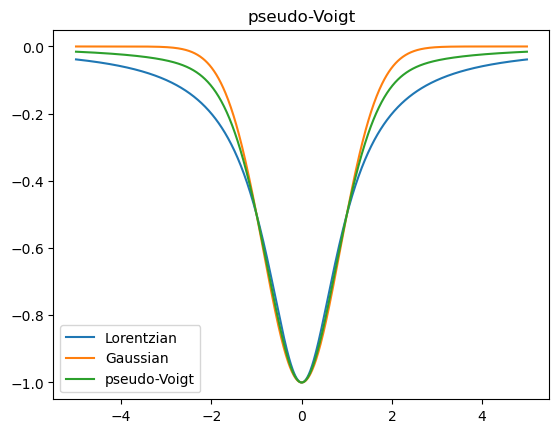

In [14]:
plt.figure()
x = np.arange(-5, 5, 0.01)

sigma = 1
gamma = np.sqrt(2 * np.log(2)) * sigma
ag = 1/(sigma * np.sqrt(2 * np.pi))
A = 0.5 * (ag + 2 / (np.pi * gamma))
plt.plot(x, -pseudo_voigts(x, 0), label="Lorentzian")
plt.plot(x, -pseudo_voigts(x, 1), label="Gaussian")
plt.plot(x, -pseudo_voigts(x, .5), label='pseudo-Voigt')
plt.legend()
plt.title("pseudo-Voigt")

## Using fitting Code to fit Potassium Doublets

In [15]:
# giving each spectra a range for the continuum and absorption
dict_of_values = {}
for name in sources:
    dict_of_values[name] = {"continuum": [
        1.15, 1.19], "absorption": [1.165, 1.183]}

dict_of_values["2MASS J08533619-0329321"]["continuum"] = [1.16, 1.192]
dict_of_values["2MASS J05591914-1404488"]["continuum"] = [1.15, 1.20]
dict_of_values["2MASS J05591914-1404488"]["absorption"] = [1.160, 1.183]
dict_of_values["2MASS J22344161+4041387"]["continuum"] = [1.15, 1.20]
dict_of_values["2MASS J22344161+4041387"]["absorption"] = [1.165, 1.183]

2MASS J08533619-0329321
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.23179916e-02  2.53832951e-02 -4.99985184e-14 -5.88867948e-14
  6.41444219e-04  7.02453314e-04  1.16934577e+00  1.17755714e+00]


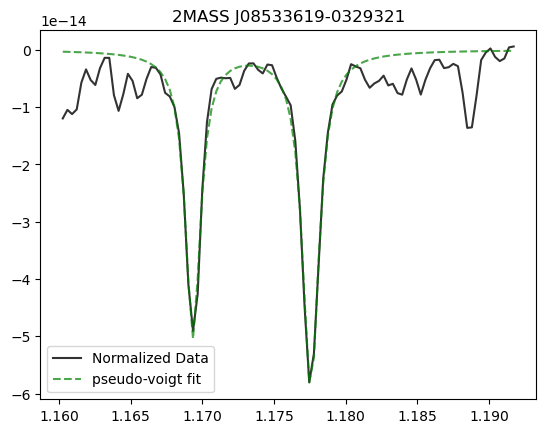

2MASS J02550357-4700509
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 2.27742714e-19  4.36169933e-19 -4.33776531e-15 -6.34274993e-15
  1.62199868e-03  1.15803280e-03  1.16921493e+00  1.17769531e+00]


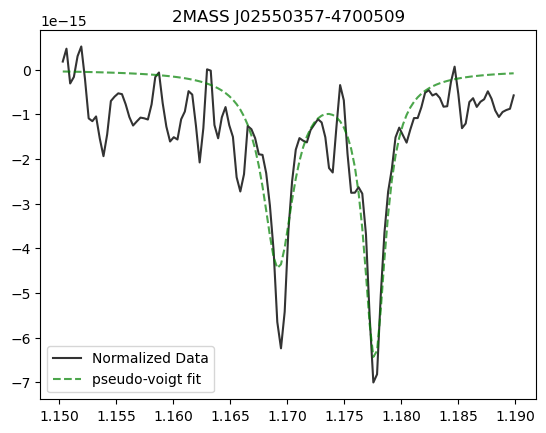

2MASS J22344161+4041387
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 4.83741736e-19  1.23983264e-18 -3.06323300e-16 -4.53041820e-16
  6.82242682e-04  6.02405261e-04  1.16891493e+00  1.17720445e+00]


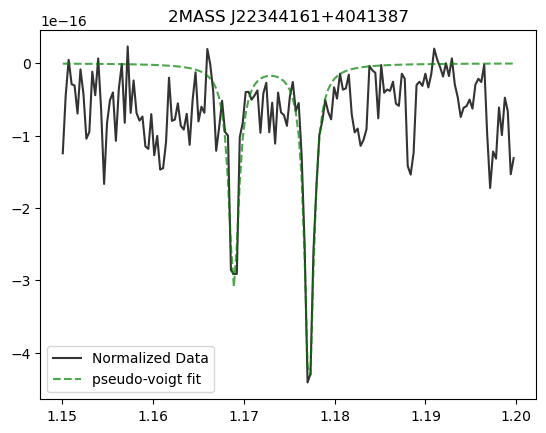

2MASS J00361617+1821104
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.21418982e-18  7.76176397e-19 -1.68178915e-16 -1.91657372e-16
  6.90875042e-04  1.02571910e-03  1.16915876e+00  1.17777608e+00]


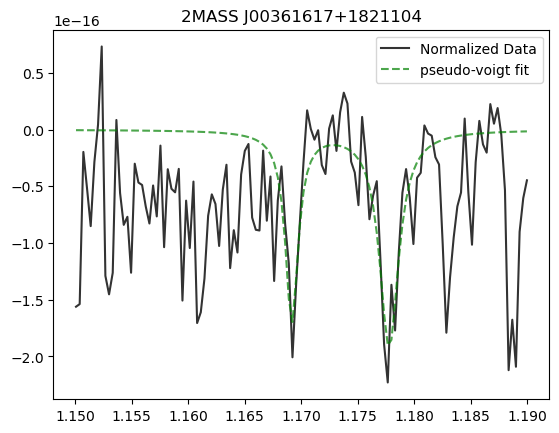

2MASS J03552337+1133437
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 3.39728331e-14  3.39728682e-14 -1.90480710e-14 -2.17251425e-14
  8.73911333e-04  9.55320837e-04  1.16928240e+00  1.17753234e+00]


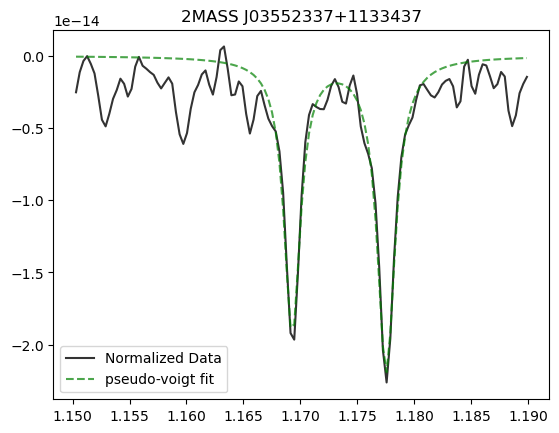

TWA 27
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.19340129e-11  1.71783495e-01 -4.15851686e-16 -6.78318022e-16
  8.24025186e-04  5.89137624e-04  1.16928837e+00  1.17758492e+00]


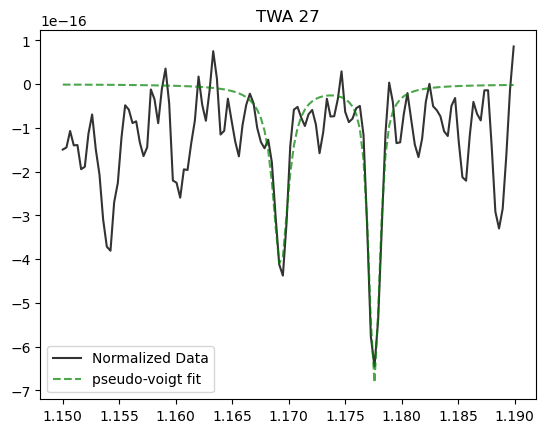

TWA 27
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.19340129e-11  1.71783495e-01 -4.15851686e-16 -6.78318022e-16
  8.24025186e-04  5.89137624e-04  1.16928837e+00  1.17758492e+00]


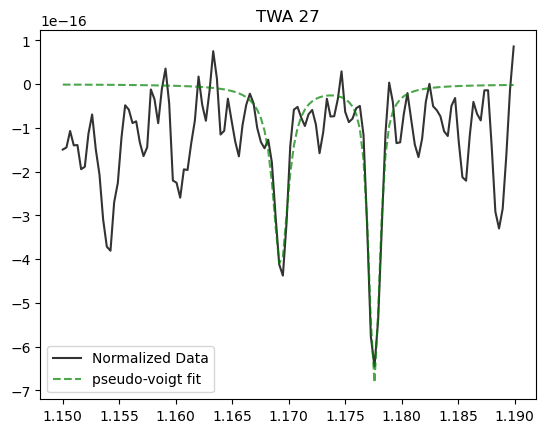

2MASS J05395200-0059019
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.00000000e+00  1.00000000e+00 -2.36815681e-16 -3.95408707e-16
  5.76845712e-04  6.46062954e-04  1.16917688e+00  1.17748478e+00]


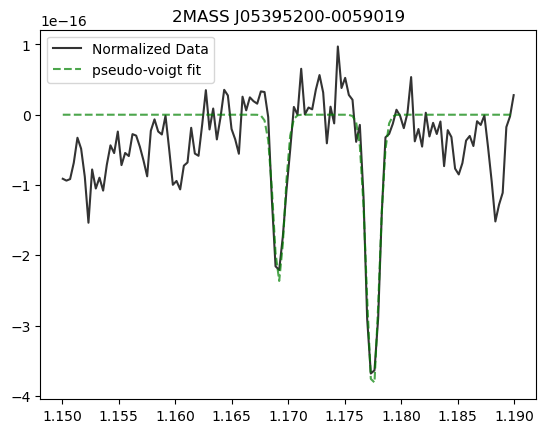

2MASS J08251968+2115521
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.16273302e-19  5.32035048e-19 -3.91742600e-15 -4.69353656e-15
  1.04168477e-03  1.07629580e-03  1.16940011e+00  1.17770612e+00]


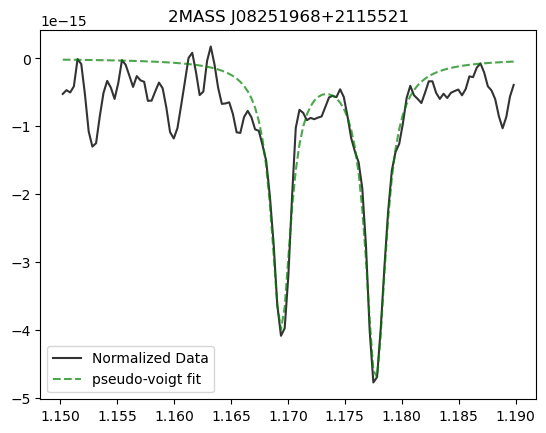

2MASS J01415823-4633574
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 2.44097432e-19  3.90000253e-19 -8.23345373e-16 -1.09720877e-15
  1.18436240e-03  7.37677401e-04  1.16952228e+00  1.17782000e+00]


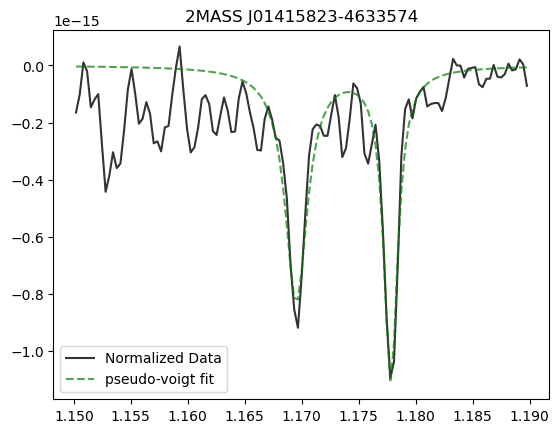

2MASS J06085283-2753583
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 1.00000000e-10  1.00000000e-10 -2.32151746e-01 -3.31626863e-01
  7.09941426e-04  7.51819558e-04  1.16948656e+00  1.17762130e+00]


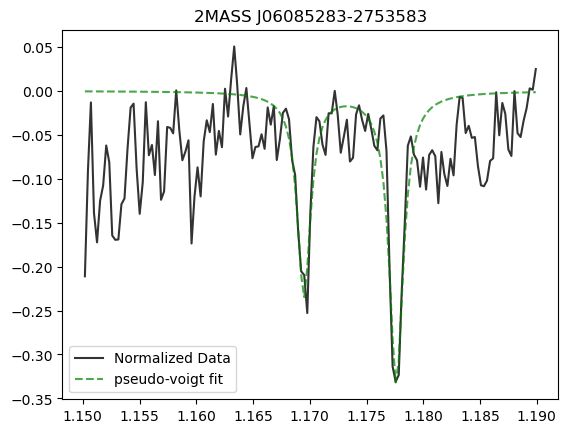

2MASS J12074836-3900043
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 7.45464209e-01  8.00959403e-02 -5.50216653e-16 -7.47065629e-16
  4.99095207e-04  5.85837715e-04  1.16909759e+00  1.17735480e+00]


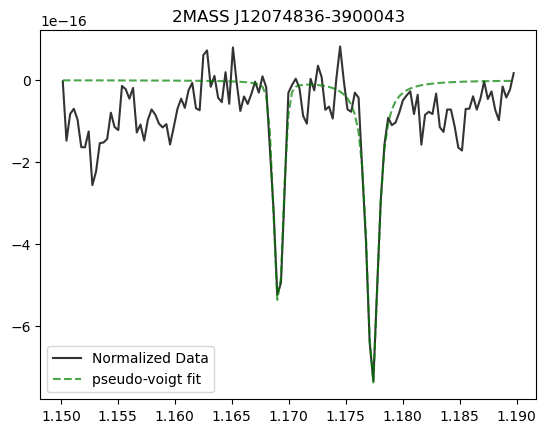

LHS 2924
curve fit: nu1, nu2 A1, A2, σ1, σ2, μ1, μ2:  [ 5.27432356e-19  1.34323369e-18 -2.84745742e-15 -3.76850112e-15
  2.88696674e-03  1.76489709e-03  1.16913186e+00  1.17768093e+00]


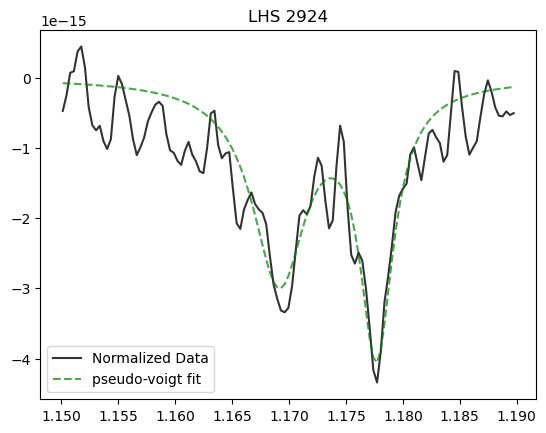

In [16]:
# fitting the potassium doublets in each
for source in good_for_fitting:
    print(source)

    fit_two_curves(dict_of_spectra[source], dict_of_values[source]["continuum"],
                   dict_of_values[source]["absorption"], function='pseudo-voigt',
                   show=True)
    
    plt.title(source)
    plt.show()

